<h1 align="center">
    <img 
        src="../img/logo_white_bg.jpeg" 
        width="200" 
        border="1" />
</h1>
<h1 align="center">
    <b>GenAISHAP</b>
</h1>
<h4 align="center">
    <i>Explanations for Generative AI, LLM-and-SLM-Based, Solutions</i> ⚡️
</h4>



Generative AI SHAP (GAISHAP) is a python library that supports the creation of explanations to the metrics obtained for solutions based on LLMs (Large Language Models) or SLMs (Small Language Models). 

In summary, ***GenAISHAP*** works as follows:  ***GenAISHAP*** will create regression models, which we call them **black-box models**, for each of the metrics and will use those black-box models to produce explanations for each metric. The models are created from features extracted from the provided questions. Those **question features** could be generated automatically, using a tool, named **Featurizer** incorporated in the library or they can be manually created.

The previous notebooks showed an example of how to:

1. create the **Input** for ***GenAISHAP***, which is a simple Pandas DataFrame with the evaluation dataset with the `user_input` column and numerical columns that defines the generative AI metrics to create explanations.
2. The next notebook showed how to use the **Featurizer** tool to automatically create the characteristics of the user inputs that are going to be used as regressors of the black-models that are going to be used to create the explainers.

This notebook shows an example of how to create and use the explainers created on top of the user inputs and the features created in the previous notebooks. The following are the steps, that need to be done:

- Feature engineering
- Regression black-box model training
- Creation of SHAP explainers


In [1]:
import pandas as pd
from genaishap import GenAIExplainer
import shap
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
shap.initjs()

# 1. Load test and features

The following cell loads the pandas dataframes related to the test dataset and features created in the previous steps. And shows a single view of all the data.

In [3]:
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_features = pd.read_json('./test-features.json', orient='records')
df_test_dataset.join(df_features)

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall,there_is_any_person_identified_in_the_question,list_of_people_identified_in_the_question,there_is_any_educational_institution_identified_in_the_question,list_of_educational_institutions_identified_in_the_question,there_is_any_programming_language_identified_in_the_question,list_of_programming_languages_identified_in_the_question,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question,is_a_question_about_personal_experiences_or_decisions,is_a_question_about_technological_innovations_or_concepts,is_a_question_about_artistic_pursuits_or_styles,is_a_question_related_to_business_or_startup_strategies
0,"In the essay, the author mentions his early ex...",[What I Worked On\n\nFebruary 2021\n\nBefore c...,The first computer the author used for program...,The first computer the author used for program...,1.000000,1.0,1.000000,True,[author],False,[],True,[programming],False,[],True,False,False,False
1,The author switched his major from philosophy ...,[I couldn't have put this into words when I wa...,The author developed an interest in AI due to ...,The two specific influences that led the autho...,0.900000,1.0,1.000000,True,[author],True,[college],False,[],False,[],True,True,False,False
2,"In the essay, the author discusses his initial...",[I couldn't have put this into words when I wa...,The author was initially drawn to AI by two ma...,The two main influences that initially drew th...,1.000000,1.0,1.000000,True,[author],False,[],False,[],False,[],True,True,False,False
3,The author mentions his shift of interest towa...,[I couldn't have put this into words when I wa...,The author shifted his interest towards Lisp b...,The author shifted his interest towards Lisp a...,0.900000,1.0,1.000000,True,[author],False,[],True,[Lisp],False,[],True,True,False,False
4,"In the essay, the author mentions his interest...",[So I looked around to see what I could salvag...,"During his time in grad school, the author att...","The author in the essay is Paul Graham, who wa...",0.846154,1.0,1.000000,True,[author],True,[grad school],False,[],False,[],True,False,True,False
5,The author discusses his decision to write a b...,[I couldn't have put this into words when I wa...,The author decided to write a book on Lisp hac...,The author decided to write a book on Lisp hac...,0.500000,1.0,1.000000,True,[author],False,[],True,[Lisp],False,[],True,True,False,False
6,"In the essay, the author mentions a quick deci...",[So I looked around to see what I could salvag...,The author made a quick decision to attempt to...,The author decided to attempt writing his diss...,1.000000,1.0,1.000000,True,[author],False,[],False,[],False,[],True,False,False,False
7,The author describes the atmosphere and practi...,"[I didn't want to drop out of grad school, but...",The author describes the atmosphere at the Acc...,"According to the author's account, the student...",1.000000,1.0,1.000000,True,"[students, faculty]",True,[Accademia di Belli Arti],False,[],False,[],False,False,True,False
8,"In the essay, the author discusses his experie...","[We actually had one of those little stoves, f...",The author describes painting still lives as d...,"In the essay, the author explains that paintin...",0.923077,1.0,1.000000,True,[author],False,[],False,[],False,[],False,False,True,False
9,The author shares his work experience at a com...,"[We actually had one of those little stoves, f...",Interleaf had added a unique feature to their ...,"Interleaf, the company where the author worked...",0.812500,1.0,0.857143,True,[author],False,[],False,[],True,[Interleaf],True,True,False,True


# 2. Initialize the GenAI Explainer object

The following cell just initializes and checks consistency of the data to be used to create the explainers

In [4]:
genai_explainer = GenAIExplainer.from_pandas(df_test_dataset, df_features)

# 3. Feature engineering

All the columns in the `df_feature` dataframe are pre-processed as follows:

1. All the **boolean** features are mapped to a numerical feature of 0s and 1s.
2. All the **list of string** features are mapped to a one-hot-vector matrix.
3. All the features with zero variance are removed.

The following cell executes the feature engineering and shows the final X that will be used to train the black-box models

In [5]:
genai_explainer.feature_engineering()
X = pd.DataFrame(genai_explainer.preprocessed_features)
pd.DataFrame(genai_explainer.metrics).join(X)

,faithfulness,context_precision,context_recall,there_is_any_person_identified_in_the_question,list_of_people_identified_in_the_question__jessica,list_of_people_identified_in_the_question__robert_morris,list_of_people_identified_in_the_question__mccarthy,list_of_people_identified_in_the_question__students,list_of_people_identified_in_the_question__artist,list_of_people_identified_in_the_question__team,...,list_of_companies_identified_in_the_question__interleaf,list_of_companies_identified_in_the_question__summer_founders_program,list_of_companies_identified_in_the_question__hacker_news,list_of_companies_identified_in_the_question__yc,list_of_companies_identified_in_the_question__y_combinator,list_of_companies_identified_in_the_question__viaweb,is_a_question_about_personal_experiences_or_decisions,is_a_question_about_technological_innovations_or_concepts,is_a_question_about_artistic_pursuits_or_styles,is_a_question_related_to_business_or_startup_strategies
0,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.900000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.900000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.846154,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.500000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.000000,1.0,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.923077,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.812500,1.0,0.857143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


# 4. Training and validation of the black-box models

The training uses a local AutoML and a Hyperparameter tuning tool to calculate the best model to fit each metric.

> During the training and selection of the best models a **t-test** is performed to evaluate if the estimated metric using the models produces a statistically related sample from the same population of the original metric: fail to reject the null hypothesis that both, the original metric and the estimated metric are samples from the same population. If the t-test rejects the null hypothesis a warning message is displayed during the creation of the explainers.  The explainers cannot be used as reference. 


In [6]:
genai_explainer.create_explainers()

Metric loop:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:297: UserWarning: There are 10 estimated values in the metric faithfulness too far from the original values. The following is the list of indexes [3, 5, 18, 19, 26, 27, 35, 36, 37, 39].
  warnings.warn(


context_precision:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:297: UserWarning: There are 23 estimated values in the metric context_precision too far from the original values. The following is the list of indexes [1, 2, 4, 6, 8, 11, 12, 13, 15, 17, 21, 22, 23, 24, 28, 32, 33, 37, 38, 39, 40, 42, 43].
  warnings.warn(


context_recall:   0%|          | 0/3 [00:00<?, ?it/s]

/workspace/src/genaishap/explainer.py:297: UserWarning: There are 6 estimated values in the metric context_recall too far from the original values. The following is the list of indexes [18, 19, 26, 27, 37, 39].
  warnings.warn(


In [7]:
genai_explainer.r2_scores_

{'faithfulness': 0.7524848644554358,
 'context_precision': 0.9999827494137198,
 'context_recall': 0.9378353738657846}

> Also, as a rule of thumb, if the `r2_score` is high (>0.75) the explanations of black-box model could be used as reference. If it is lower, the use of the explainers could produce misleading conclusions.

Just as an example, let's use **context_recall** for now.  It is possible, at this point to generate explanations at the full dataset level to answer questions like: *What are the more relevant features of the questions that drives a higher, or lower **context_recall**?*

# 5. Dataset level explainers

In [8]:
metric = 'context_recall'

X = pd.DataFrame(genai_explainer.preprocessed_features)
metric_explainer = genai_explainer.explainers_[metric]
shap_values = metric_explainer(X)

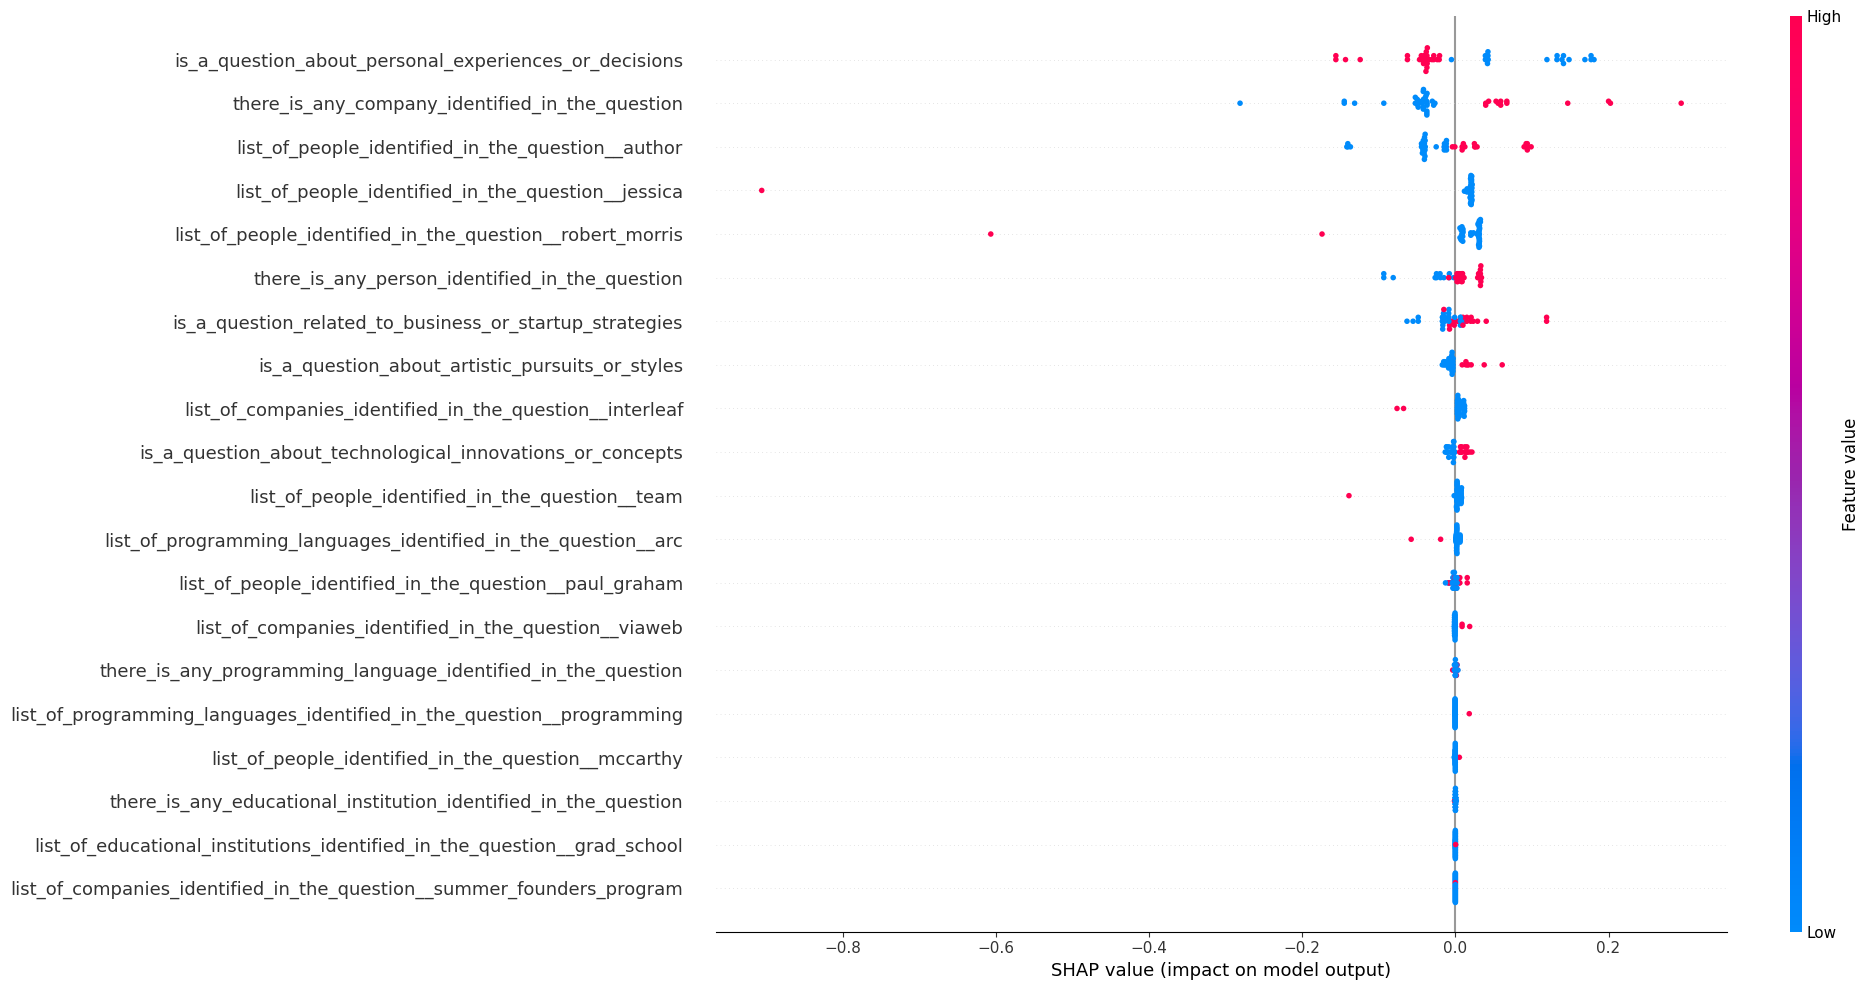

In [9]:
shap.summary_plot(shap_values, X, plot_size=(20,10))

> From this plot we can conclude, for example, that the **context recall**:
> - Is higher when the question is not about personal experiences or decisions.
> - In contrast, questions where it is possible to identify a company or there is an explicit reference to the author have higher **context recall**.
> 
> This type of information can be used as insights to guide next steps to improve the overall **context recall** of the solution.

# 6. Instance level explainers

During the creation of the explainers other warnings related to the safe use of the explainers can be raised. For example warinings like the following can be risen when creating the explainers for the **faithfulness** metric:

> `UserWarning: There are 6 estimated values in the metric context_recall too farm from the original values. The following is the list of indexes [18, 19, 26, 27, 37, 39].`

These warnings are shown because during the creation of the training of the black-box model to create the explainers, there is a process to evaluate how far are the estimated values of each metric compared to the original one, using t-distribution and confidence intervals.  If an instance is out of the confidence interval it is marked as too far from the original value and the warning is shown to alert the user to use carefully the instance explanations for those specific instances.

The following table shows a comparison of the original metric values compared with the estimated values calculated using the black-box model, and the identification if the instance is **out of range** and therefore the explanations should be used carefully for those instances.


In [10]:
df_metric = pd.DataFrame(genai_explainer.metrics)[[metric]]
df_metric['estimated_value'] = genai_explainer.estimators_[metric].predict(X)
df_metric['is_out_of_range'] = genai_explainer.is_out_of_range_[metric]

df_metric.style.apply(
    lambda s : [
        'background-color: yellow' if s.loc['is_out_of_range'] else '' for v in s.index
    ], axis=1)

,context_recall,estimated_value,is_out_of_range
0,1.000000,1.000999,False
1,1.000000,0.999139,False
2,1.000000,1.001824,False
3,1.000000,0.999603,False
4,1.000000,1.000825,False
5,1.000000,0.999603,False
6,1.000000,0.992822,False
7,1.000000,1.000032,False
8,1.000000,1.000785,False
9,0.857143,0.858178,False


As an example let's pick the 14th index, which has a **context recall** of 0, and an extimated value of 0.001. The following are the details of that instance:

In [11]:
index = 14

context = df_test_dataset.loc[index,'retrieved_contexts']
context_str = "\n".join([f"\n**CHUNK {i+1}:**\n\n{c}" for i, c in zip(range(len(context)),context)])


index_details = f"""
### INDEX {index}

**USER INPUT:**
{df_test_dataset.loc[index,'user_input']}

**RETRIEVED CONTEXT:**

{context_str}

**RESPONSE:**
{df_test_dataset.loc[index,'response']}

**REFERENCE:**
{df_test_dataset.loc[index,'reference']}

**METRIC:** {metric}

**METRIC Value:** {df_test_dataset.loc[index, metric]:.3f}

**MODEL ESTIMATED Value:** {df_metric.loc[index, 'estimated_value']:.3f}
"""

display(Markdown(index_details))


### INDEX 14

**USER INPUT:**
In the essay by Paul Graham, what was the initial idea for a startup that he and Robert Morris had, and why did it fail?

**RETRIEVED CONTEXT:**


**CHUNK 1:**

Over the next several years I wrote lots of essays about all kinds of different topics. O'Reilly reprinted a collection of them as a book, called Hackers & Painters after one of the essays in it. I also worked on spam filters, and did some more painting. I used to have dinners for a group of friends every thursday night, which taught me how to cook for groups. And I bought another building in Cambridge, a former candy factory (and later, twas said, porn studio), to use as an office.

One night in October 2003 there was a big party at my house. It was a clever idea of my friend Maria Daniels, who was one of the thursday diners. Three separate hosts would all invite their friends to one party. So for every guest, two thirds of the other guests would be people they didn't know but would probably like. One of the guests was someone I didn't know but would turn out to like a lot: a woman called Jessica Livingston. A couple days later I asked her out.

Jessica was in charge of marketing at a Boston investment bank. This bank thought it understood startups, but over the next year, as she met friends of mine from the startup world, she was surprised how different reality was. And how colorful their stories were. So she decided to compile a book of interviews with startup founders.

When the bank had financial problems and she had to fire half her staff, she started looking for a new job. In early 2005 she interviewed for a marketing job at a Boston VC firm. It took them weeks to make up their minds, and during this time I started telling her about all the things that needed to be fixed about venture capital. They should make a larger number of smaller investments instead of a handful of giant ones, they should be funding younger, more technical founders instead of MBAs, they should let the founders remain as CEO, and so on.

One of my tricks for writing essays had always been to give talks. The prospect of having to stand up in front of a group of people and tell them something that won't waste their time is a great spur to the imagination. When the Harvard Computer Society, the undergrad computer club, asked me to give a talk, I decided I would tell them how to start a startup. Maybe they'd be able to avoid the worst of the mistakes we'd made.

So I gave this talk, in the course of which I told them that the best sources of seed funding were successful startup founders, because then they'd be sources of advice too. Whereupon it seemed they were all looking expectantly at me. Horrified at the prospect of having my inbox flooded by business plans (if I'd only known), I blurted out "But not me!" and went on with the talk. But afterward it occurred to me that I should really stop procrastinating about angel investing. I'd been meaning to since Yahoo bought us, and now it was 7 years later and I still hadn't done one angel investment.

Meanwhile I had been scheming with Robert and Trevor about projects we could work on together. I missed working with them, and it seemed like there had to be something we could collaborate on.

As Jessica and I were walking home from dinner on March 11, at the corner of Garden and Walker streets, these three threads converged. Screw the VCs who were taking so long to make up their minds. We'd start our own investment firm and actually implement the ideas we'd been talking about. I'd fund it, and Jessica could quit her job and work for it, and we'd get Robert and Trevor as partners too. [13]

Once again, ignorance worked in our favor. We had no idea how to be angel investors, and in Boston in 2005 there were no Ron Conways to learn from. So we just made what seemed like the obvious choices, and some of the things we did turned out to be novel.

There are multiple components to Y Combinator, and we didn't figure them all out at once. The part we got first was to be an angel firm. In those days, those two words didn't go together. There were VC firms, which were organized companies with people whose job it was to make investments, but they only did big, million dollar investments. And there were angels, who did smaller investments, but these were individuals who were usually focused on other things and made investments on the side. And neither of them helped founders enough in the beginning. We knew how helpless founders were in some respects, because we remembered how helpless we'd been. For example, one thing Julian had done for us that seemed to us like magic was to get us set up as a company.

**CHUNK 2:**

So we just made what seemed like the obvious choices, and some of the things we did turned out to be novel.

There are multiple components to Y Combinator, and we didn't figure them all out at once. The part we got first was to be an angel firm. In those days, those two words didn't go together. There were VC firms, which were organized companies with people whose job it was to make investments, but they only did big, million dollar investments. And there were angels, who did smaller investments, but these were individuals who were usually focused on other things and made investments on the side. And neither of them helped founders enough in the beginning. We knew how helpless founders were in some respects, because we remembered how helpless we'd been. For example, one thing Julian had done for us that seemed to us like magic was to get us set up as a company. We were fine writing fairly difficult software, but actually getting incorporated, with bylaws and stock and all that stuff, how on earth did you do that? Our plan was not only to make seed investments, but to do for startups everything Julian had done for us.

YC was not organized as a fund. It was cheap enough to run that we funded it with our own money. That went right by 99% of readers, but professional investors are thinking "Wow, that means they got all the returns." But once again, this was not due to any particular insight on our part. We didn't know how VC firms were organized. It never occurred to us to try to raise a fund, and if it had, we wouldn't have known where to start. [14]

The most distinctive thing about YC is the batch model: to fund a bunch of startups all at once, twice a year, and then to spend three months focusing intensively on trying to help them. That part we discovered by accident, not merely implicitly but explicitly due to our ignorance about investing. We needed to get experience as investors. What better way, we thought, than to fund a whole bunch of startups at once? We knew undergrads got temporary jobs at tech companies during the summer. Why not organize a summer program where they'd start startups instead? We wouldn't feel guilty for being in a sense fake investors, because they would in a similar sense be fake founders. So while we probably wouldn't make much money out of it, we'd at least get to practice being investors on them, and they for their part would probably have a more interesting summer than they would working at Microsoft.

We'd use the building I owned in Cambridge as our headquarters. We'd all have dinner there once a week â on tuesdays, since I was already cooking for the thursday diners on thursdays â and after dinner we'd bring in experts on startups to give talks.

We knew undergrads were deciding then about summer jobs, so in a matter of days we cooked up something we called the Summer Founders Program, and I posted an announcement on my site, inviting undergrads to apply. I had never imagined that writing essays would be a way to get "deal flow," as investors call it, but it turned out to be the perfect source. [15] We got 225 applications for the Summer Founders Program, and we were surprised to find that a lot of them were from people who'd already graduated, or were about to that spring. Already this SFP thing was starting to feel more serious than we'd intended.

We invited about 20 of the 225 groups to interview in person, and from those we picked 8 to fund. They were an impressive group. That first batch included reddit, Justin Kan and Emmett Shear, who went on to found Twitch, Aaron Swartz, who had already helped write the RSS spec and would a few years later become a martyr for open access, and Sam Altman, who would later become the second president of YC. I don't think it was entirely luck that the first batch was so good. You had to be pretty bold to sign up for a weird thing like the Summer Founders Program instead of a summer job at a legit place like Microsoft or Goldman Sachs.

The deal for startups was based on a combination of the deal we did with Julian ($10k for 10%) and what Robert said MIT grad students got for the summer ($6k). We invested $6k per founder, which in the typical two-founder case was $12k, in return for 6%. That had to be fair, because it was twice as good as the deal we ourselves had taken. Plus that first summer, which was really hot, Jessica brought the founders free air conditioners.

**RESPONSE:**
The essay does not provide specific details about an initial startup idea that Paul Graham and Robert Morris had, nor does it mention why such an idea might have failed.

**REFERENCE:**
The initial idea for a startup by Paul Graham and Robert Morris was to put art galleries online. The idea failed because art galleries didn't want to be online, especially the fancy ones, as that's not how they sell. They wrote software to generate web sites for galleries and to resize images and set up an http server to serve the pages, but they struggled to sign up galleries. Even when they offered to make sites for free, they couldn't get galleries to pay for the service.

**METRIC:** context_recall

**METRIC Value:** 0.000

**MODEL ESTIMATED Value:** 0.001


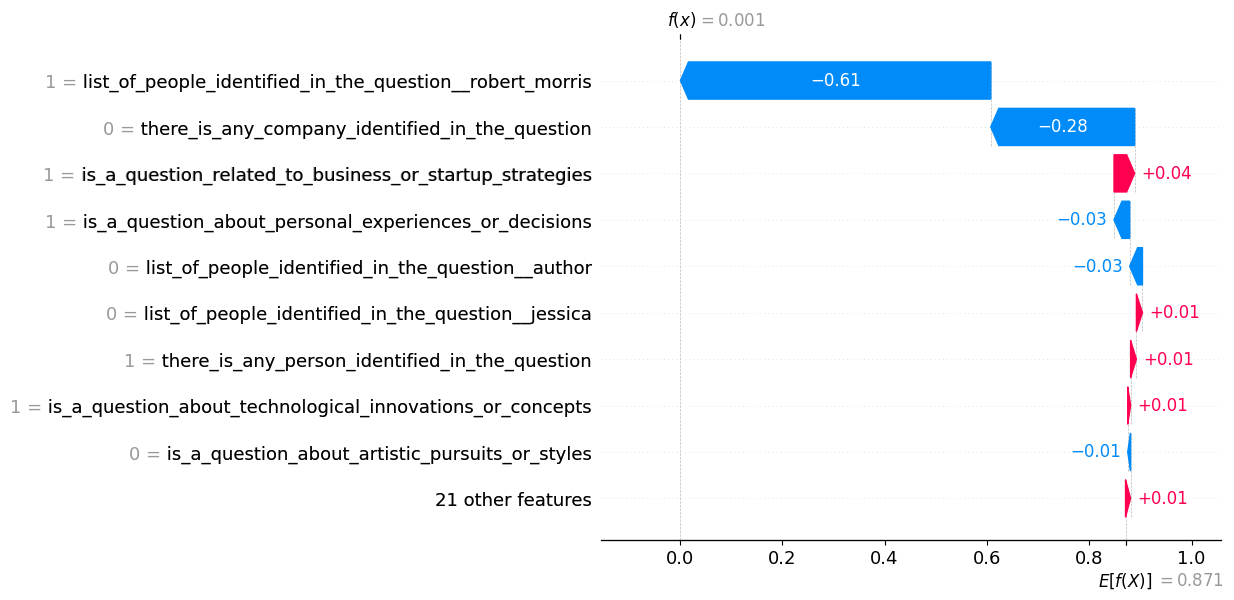

In [12]:
shap.waterfall_plot(shap_values[index])

> The horizontal axis of the SHAP waterfall plot shows the contributions of individual features to the model's prediction for a specific instance. The sum of all the contributions will be the final instance predicted value. 
>
> From this plot we can conclude that the reduction of the **context recall** for this specific instance was mainly driven by the explicit mention of "Robert Morris" and because it is a question with no mention of any specific company in the question.  Looking at the details of this instance we can conclude that LlamaIndex was not able to pick the right documents that includes the answer to the question, and that the drivers of the error could be the combination of the mention of Robert Morris together with the absence of the mention of a specific company.
> 
> This type of information add insights at the instance level on how to improve the overal quality of the solution.
